"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."

In [1]:
!pip install Box2D
# !pip3 install -U 'mujoco-py<2.2,>=2.1'
# !apt-get install -y \
#     libgl1-mesa-dev \
#     libgl1-mesa-glx \
#     libglew-dev \
#     libosmesa6-dev \
#     software-properties-common

# !apt-get install -y patchelf
# !pip install free-mujoco-py
# import mujoco_py
# import os
# mj_path = mujoco_py.utils.discover_mujoco()
# xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
# model = mujoco_py.load_model_from_path(xml_path)
# sim = mujoco_py.MjSim(model)

     |████████████████████████████████| 1.3 MB 7.7 MB/s 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
# from gym import spaces
import tensorflow as tf
import random, math, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
bipedal_env = gym.make('BipedalWalker-v3')
bipedal_env.reset()
print(bipedal_env.action_space.shape)
print(bipedal_env.observation_space.shape)
print(bipedal_env.observation_space.high)
print(bipedal_env.observation_space.low)


(4,)
(24,)
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Below is the replay buffer class

In [3]:
class Agent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

Below is the NN initialization, training class

> Indented block



In [4]:
def helper(numpy_array):
  arg = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
  return arg

In [54]:
class Actor:
  def __init__(self, alfr, actor_input_state_dim, actor_output_action_dim):
    self.model = self.actor_network_model(alfr, actor_input_state_dim, actor_output_action_dim)
    self.opt = tf.keras.optimizers.Adam(0.0005)

  def actor_network_model(self, alr, actor_input_state_dim,actor_output_action_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=actor_input_state_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actor_output_action_dim, activation='softmax'))
    return model

  def actor_train(self, obs, action, adv):
    with tf.GradientTape() as tape:
      actor_pred = self.model(obs, training=True)
      actor_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(action, tf.reshape(actor_pred,(4,1)),sample_weight=tf.stop_gradient(adv))
    grads = tape.gradient(actor_loss, self.model.trainable_variables)
    self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
    return actor_loss

In [55]:
class Critic:
  def __init__(self, clr, critic_input_state_dim, critic_output_action_dim):
    self.model = self.critic_network_model(clr, critic_input_state_dim, critic_output_action_dim)
    self.opt = tf.keras.optimizers.Adam(0.0005)

  def critic_network_model(self,clr,critic_input_state_dim,critic_output_action_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=critic_input_state_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(critic_output_action_dim, activation='linear'))
    return model
    
  def critic_train(self, obs, adv):
    with tf.GradientTape() as tape:
      critic_pred = self.model(obs, training=True)
      critic_loss = tf.keras.losses.MeanSquaredError()(tf.stop_gradient(adv), critic_pred)
    critic_grads = tape.gradient(critic_loss, self.model.trainable_variables)
    self.opt.apply_gradients(zip(critic_grads, self.model.trainable_variables))
    return critic_loss

In [56]:
class A2C:
  def __init__(self,env,agent):
    self.env = env
    self.agent = agent
    self.observation_space = env.observation_space
    self.obervation_size = env.observation_space.shape[0]
    self.action_space = env.action_space
    self.reward_per_episode = []
    self.average_reward = [0]*10

  def train(self,episodes,gamma,actor_lr, critic_lr):
    obs = self.env.reset()
    action_size = self.env.action_space.shape[0]
    self.actor = Actor(actor_lr,self.obervation_size,action_size)
    self.critic = Critic(critic_lr,self.obervation_size,1)
    average_idx = 0

    #print("8: episodes begin")
    for eps_n in range(episodes):
        obs = self.env.reset()
        done_iter = False
        cumm_reward=0
        step_no=1

        #print("9: steps start for episode {}".format(str(eps_n)))
        while not done_iter:
          
          obs_reshaped = tf.reshape(helper(obs),(1,self.obervation_size))

          next_q = self.actor.model.predict(obs_reshaped)
          #print("next_q: {}".format(next_q))

          action_prob = tfp.distributions.Categorical(probs=next_q)
          #print("action_prob {}".format(action_prob))
          action = action_prob.sample(sample_shape=4)
          
          action_reshaped = tf.reshape(action,(1,4))
          #print("action_reshaped {}".format(action_reshaped))
          action_numpy = tf.gather(action_reshaped,0).numpy()
          action_reshaped = tf.reshape(helper(action_numpy),(1,4))
          #print("action_reshaped: {}".format(action_reshaped.shape))

          obs_next, reward, done_iter, info = self.env.step(action_numpy)
          #print("obs_next: {}".format(obs_next))
          #print("reward: {}".format(reward))
          #print("done_iter: {}".format(done_iter))
          #print("info: {}".format(info))

          critic_obs = self.critic.model.predict(obs_reshaped) 
          #print("critic_obs: {}".format(critic_obs))

          obs_next_reshaped = tf.reshape(helper(obs_next),(1,self.obervation_size))
          critic_obs_next = self.critic.model.predict(obs_next_reshaped) 
          #print("critic_obs_next: {}".format(critic_obs_next))

          adv = reward + (1-done_iter)*gamma*critic_obs_next - critic_obs
          #print("self.adv: {}".format(self.adv))

          critic_loss = self.critic.critic_train(obs_reshaped, adv+critic_obs)
          actor_loss = self.actor.actor_train(obs_reshaped,tf.reshape(action,(4,1)), adv)

          cumm_reward += reward
          obs = obs_next
          step_no += 1

        self.reward_per_episode.append(cumm_reward)
        average_idx = 0 if average_idx == 9 else 1 + average_idx
        self.average_reward[average_idx] = cumm_reward
        avg_reward = int(sum(self.average_reward)/len(self.average_reward))
        if avg_reward >300: 
          break 
          print("average reward for the last consecutive episodes is "+ avg_reward +"greater than 470")
        print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  

          
          

In [57]:

agent = Agent(bipedal_env)

number_of_episodes = 5000

a2c = A2C(bipedal_env,agent)

a2c.train(episodes = number_of_episodes,gamma = 0.99, actor_lr = 0.001, critic_lr = 0.001)

cummulative reward is -92.70290598967547 for episode no. 1
cummulative reward is -92.06127721544665 for episode no. 2
cummulative reward is -92.09561301899764 for episode no. 3
cummulative reward is -92.03975625879443 for episode no. 4
cummulative reward is -91.90903954448488 for episode no. 5
cummulative reward is -91.77908975367124 for episode no. 6
cummulative reward is -91.98761361992608 for episode no. 7
cummulative reward is -91.88519907013203 for episode no. 8
cummulative reward is -91.8197577140915 for episode no. 9
cummulative reward is -92.06680057073633 for episode no. 10
cummulative reward is -91.85878359441026 for episode no. 11
cummulative reward is -92.07469002871464 for episode no. 12
cummulative reward is -92.04736001991357 for episode no. 13
cummulative reward is -91.99637832290804 for episode no. 14
cummulative reward is -91.94227090384811 for episode no. 15
cummulative reward is -91.9560950352655 for episode no. 16
cummulative reward is -91.98463897888239 for episod

KeyboardInterrupt: ignored

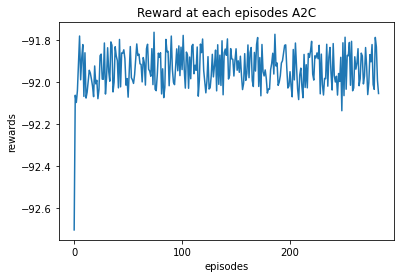

In [58]:
#Reward at each iteration DQ-Learning
plt.plot(a2c.reward_per_episode) 
plt.xticks(range(0,len(a2c.reward_per_episode)+1, 100)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes A2C") 
plt.show()

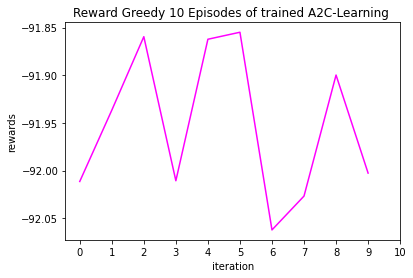

In [63]:
#evaluate Q learning
gamma = 0.99

reward_A2Clearning_10ep = []
for i in np.arange(10):
    obs = a2c.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0

    while not done_iter:
      obs_reshaped = tf.reshape(helper(obs),(1,24))
      next_q = a2c.actor.model.predict(obs_reshaped)
      action_dist = tfp.distributions.Categorical(probs=next_q)
      action = action_dist.sample(sample_shape=4)
      action_reshaped = tf.reshape(action,(1,4))
      #print("action_reshaped {}".format(action_reshaped))
      action_numpy = tf.gather(action_reshaped,0).numpy()
      obs_next, reward, done_iter, info = a2c.env.step(action_numpy)
      #action = int(a2c.greedy_act_max(obs.reshape(1,4)))
      cumm_reward += reward
      obs = obs_next
      # done_iter = done
      step_no += 1
    reward_A2Clearning_10ep.append(cumm_reward)

plt.plot(reward_A2Clearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_A2Clearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained A2C-Learning ") 
plt.show()